## Monte Carlo Algorithm

### Librairies 

In [3]:
from random import randint, random
from math import exp

### Others functions

In [4]:
import import_ipynb
from Others_Functions import *
from Neighbourhoods import *
from Grid import *

#### Monte Carlo 2D

In [5]:
def E(c, hp_sequence):
    """
    Args:
        c (list of tuples): List of (x, y) coordinates of residues.
        hp_sequence (str): String representing the HP sequence (Example: "HPPH").

    Returns:
        int: Energy of the conformation.
    """

    # List of indices of H residues
    h_indices = [i for i, residue in enumerate(hp_sequence) if residue == 'H']
    energy = 0

    # Iterate through all pairs of non-consecutive H residues
    for i in range(len(h_indices)):
        for j in range(i + 1, len(h_indices)):
            idx_i = h_indices[i]
            idx_j = h_indices[j]

            # Check if residues are not consecutive in the sequence
            if abs(idx_i - idx_j) > 1:
                # Check if residues are adjacent on the lattice
                if abs(c[idx_i][0] - c[idx_j][0]) + abs(c[idx_i][1] - c[idx_j][1]) == 1:
                    energy -= 1  # Each H-H contact contributes -1 to the energy
    return energy


In [6]:
def MCsearch(phi, c, hp, T=220):
    """
    Perform a Monte Carlo search to find a low-energy conformation of an HP sequence.

    Args:
        phi (int): Number of iterations/moves to perform.
        c (list of tuples): Current conformation as a list of (x, y) coordinates.
        hp (str): HP sequence (Ewample : "HPPHHPH").
        T (float, optional): Temperature parameter for Metropolis criterion. Defaults to 220.

    Returns:
        tuple: (final_conformation, final_energy, best_conformation, best_energy)
    """
    n = len(c)
    c_mini = c.copy()
    E_mini = E(c, hp)  # Calculate initial energy
    total_changes = 0

    for i in range(phi):
        c_prime = c.copy() 
        k = randint(1, len(c)-1)  # Choose a random residue (1-based index)
        change, c_prime = M_vshd(c_prime, k)  # Apply a random VSHD move

        total_changes += change

        # Calculate energy differences
        delta_E = E(c_prime, hp) - E(c, hp)  # Energy difference with current conformation
        delta_E_mini = E(c_prime, hp) - E_mini  # Energy difference with best conformation found

        # Always accept if energy decreases or stays the same
        if delta_E <= 0:
            c = c_prime

            # Update best conformation if this one is better
            if delta_E_mini < 0:
                c_mini = c_prime
                E_mini = E(c_prime, hp)

        else:
            q = random()  # Generate a random number between 0 and 1
            # Metropolis criterion : accept with certain probability if energy increases
            if q < (1 / (exp(1) ** (delta_E / T))):
                c = c_prime  

    # Return final conformation, its energy, best conformation found, and its energy
    return c, E(c, hp), c_mini, E_mini, total_changes

### REMC

In [ ]:
def REMCSimulation(phi, c, hp, E_star, T_init=160, T_final=220, chi=5):
    """
    Perform a Replica Exchange Monte Carlo (REMC) simulation to find a low-energy conformation of an HP sequence.

    Args:
        phi (int): Number of iterations/moves to perform for each replica.
        c (list of tuples): Initial conformation as a list of (x, y) coordinates.
        hp (str): HP sequence (Example: "HPPHHPH").
        E_star (int): Target energy level for the simulation.
        T_init (float, optional): Minimum temperature. Defaults to 160.
        T_final (float, optional): Maximum temperature. Defaults to 220.
        chi (int, optional): Number of replicas to simulate. Defaults to 5.

    Returns:
        tuple: (best_conformation, best_energy)
    """
    # Create linear temperature schedule
    temperatures = [T_init + i * (T_final - T_init) / (chi - 1) for i in range(chi)]

    # Initialize replicas with the same initial conformation and energy
    replicas = [(c.copy(), E(c, hp)) for _ in range(chi)]

    # Track best conformation and energy
    best_conformation = c.copy()
    best_energy = E(c, hp)
    current_best_energy = float('inf')
    offset = 0

    # Maximum number of iterations to prevent infinite loops
    max_iterations = 1000
    iteration = 0

    while current_best_energy > E_star and iteration < max_iterations:
        iteration += 1
        print(iteration)

        # Perform MC search for each replica
        for k in range(chi):
            # Perform MC search
            new_conformation, new_energy, _, _, _ = MCsearch(phi, replicas[k][0], hp, temperatures[k])
            replicas[k] = (new_conformation, new_energy)

            # Update best conformation if needed
            if new_energy < current_best_energy:
                current_best_energy = new_energy
                best_conformation = new_conformation.copy()
                best_energy = new_energy

        # Attempt replica exchanges between neighboring temperatures
        i = offset
        while i + 1 < chi:  # Fixed condition to avoid index errors
            j = i + 1

            # Calculate exchange probability
            delta = (1/temperatures[j] - 1/temperatures[i]) * (replicas[i][1] - replicas[j][1])

            # Accept exchange with Metropolis criterion
            if delta <= 0:
                # Always accept if energy difference is favorable
                replicas[i], replicas[j] = replicas[j], replicas[i]
            else:
                # Accept with probability if energy difference is unfavorable
                if random() < exp(-delta):
                    replicas[i], replicas[j] = replicas[j], replicas[i]

            i += 2  # Move to next pair of replicas

        # Toggle offset for next iteration
        offset = 1 - offset

    return best_conformation, best_energy


## Tests

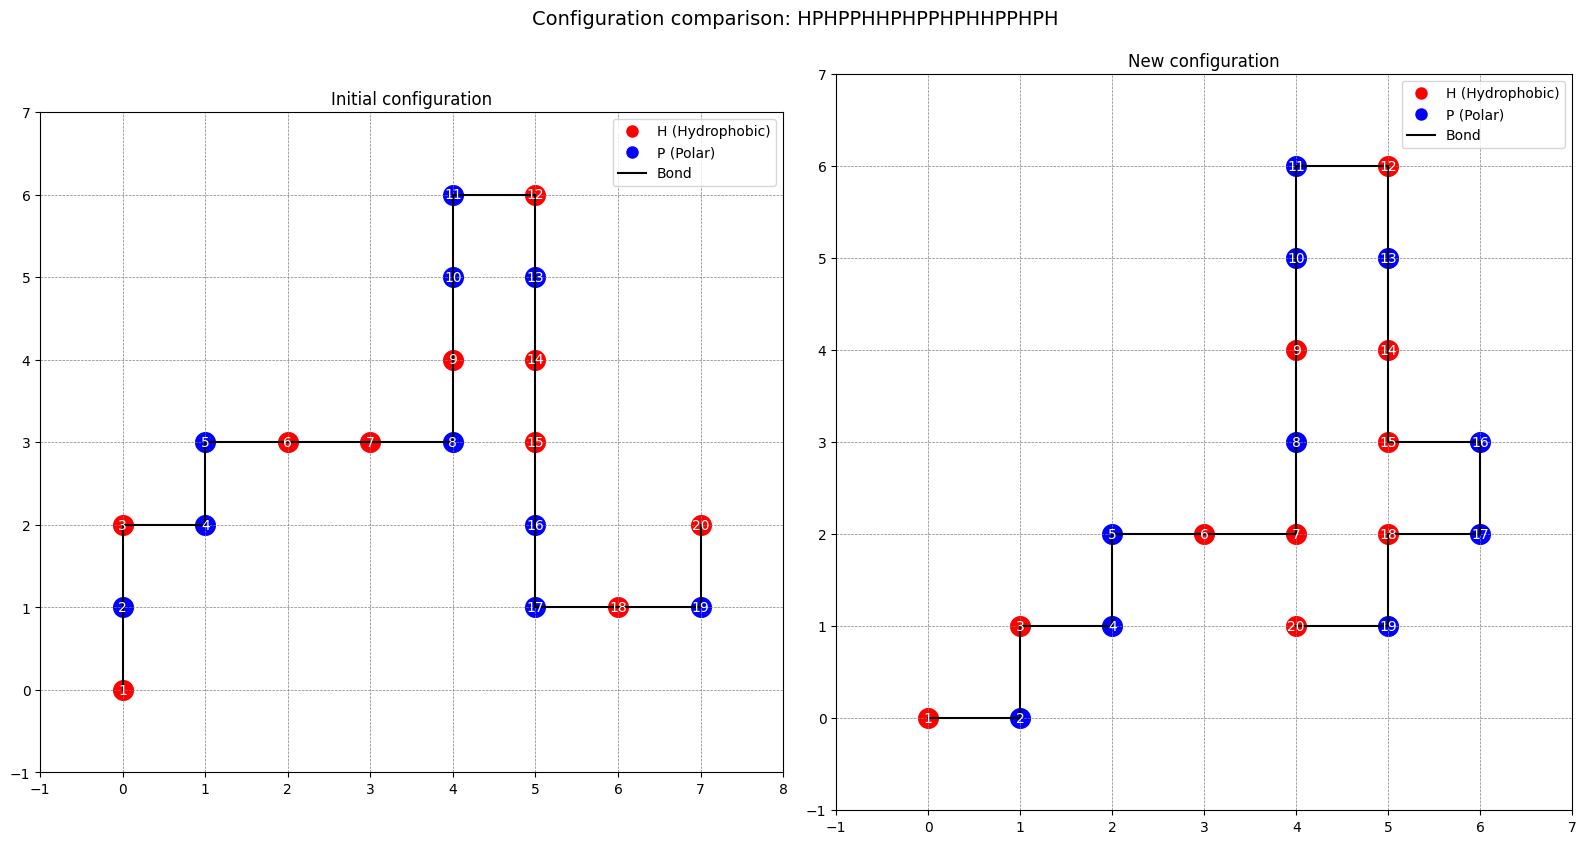

Energie:-4
Total changes:209


In [8]:
# ----- Tests Montecarlo -----
hp = "HPPHHPPHHP"
hp = "HHHHHHHHHH"
hp = "HPHPHPHPHP"
hp = "HPPHPPHPPH"
c = [(2, -2), (2, -1), (2, 0), (2, 1), (1, 1), 
    (1, 2), (0, 2), (0, 1), (-1, 1), (-1, 0)]
#cp = MCsearch(100000,c,hp)
#plot_molecules_side_by_side(c, cp[2], hp)
#print(cp[3])



hp = "HPHPPHHPHPPHPHHPPHPH"   # L'article indique E*=-9
c = generate_random_conformation(hp)
cp = MCsearch(500,c,hp)
plot_molecules_side_by_side(c, cp[2], hp)
print('Energie:'+ str(cp[3]))
print('Total changes:'+ str(cp[4]))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


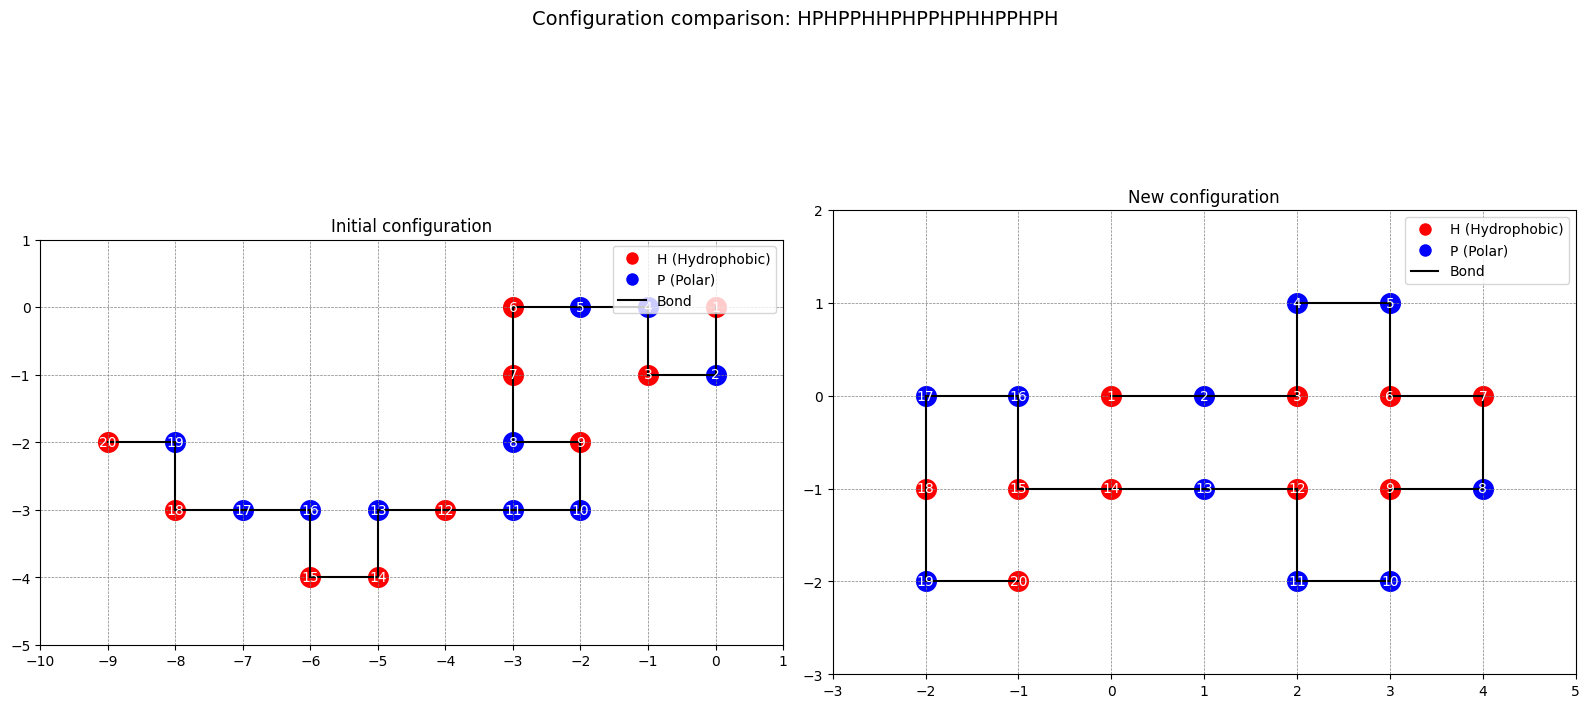

Energie:-7


IndexError: tuple index out of range

In [ ]:

hp = "HPHPPHHPHPPHPHHPPHPH"   # L'article indique E*=-9
c = generate_random_conformation(hp)
cp = REMCSimulation(500,c,hp,-9)
plot_molecules_side_by_side(c, cp[0], hp)
print('Energie:'+ str(cp[1]))